### Pol Gràcia 1533358
### Miguel Esteban 


## Projecció prespectiva

In [127]:
import numpy as np    
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

path = os.listdir('imatges/')
path_img = ['imatges/'+ n for n in path if 'Patro' not in n]
path_patro = 'imatges/Patro.png'

### 1 Read pattern

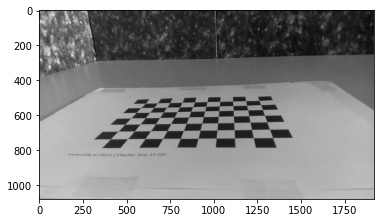

In [128]:
pattern = cv2.imread(path_patro)
pattern_gray =  cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)
plt.imshow(pattern_gray, cmap = 'gray')

In [129]:
retval, corners = cv2.findChessboardCorners(pattern_gray, (10, 7), None)

### Subcorners

In [130]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
corners2 = cv2.cornerSubPix(pattern_gray,corners, (11,11), (-1,-1), criteria)

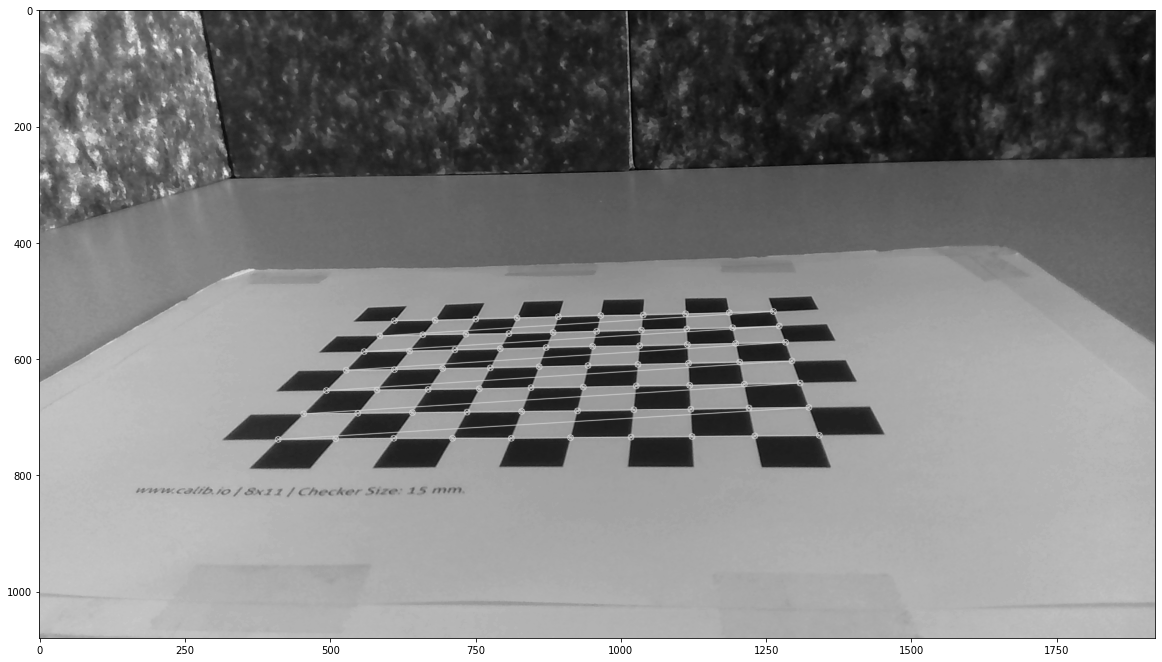

In [131]:
im = cv2.drawChessboardCorners(pattern_gray, (10,7), corners2, retval)

fig = plt.figure(figsize=(20,20))
plt.imshow(im, cmap = 'gray')


### Homography

In [132]:
pattern = cv2.imread(path_patro)
pattern_gray =  cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)

w = int((30 * 9) + (30*9*1.5))
h= int((30*6) + (30*6*1.5))
print(w,h)
x_p = [(30*9*0.75) + 30 * n for n in range(10)]
y_p = [(30*6*0.75) + 30 * n for n in range(7)]

675 450


In [133]:
m = np.zeros_like(corners2)
c = 0
for y in y_p:
    for x in x_p:
        m[c] = np.array([x,y])
        c += 1

In [134]:
h ,status = cv2.findHomography(corners2,m)

In [135]:
im_dst = cv2.warpPerspective(pattern_gray, h, (675,450))

/tmp/ipykernel_4956/4061484973.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


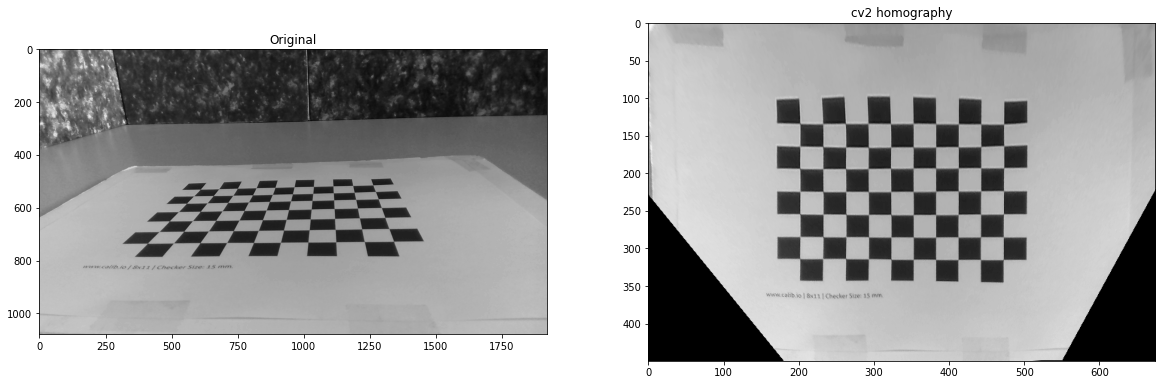

In [136]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (20,20))
ax0.title.set_text('Original')
ax0.imshow(pattern_gray, cmap = 'gray')
ax1.title.set_text('cv2 homography')
ax1.imshow(im_dst, cmap = 'gray')
fig.show()

## 2 Mètode mínims quadrats per l'homografia

In [137]:
A = np.array([(xs, ys, 1, 0, 0 , 0, -xd*xs, -xd*ys, -xd) if (c%2 == 0) else (0, 0, 0, xs, ys , 1, -yd*xs, -yd*ys, -yd)\
    for c, ((xs,ys),(xd,yd)) in enumerate([(a[0],b[0]) for a,b in zip(corners2, m)])])

V, S, C = np.linalg.svd(A)

H = (C[-1,:]/C[-1,-1]).reshape(3,3)

In [138]:
H, h

(array([[-1.97478356e+00, -3.66893633e+00,  2.31683368e+03],
        [-2.05413287e-01, -6.58938985e+00,  3.07853948e+03],
        [-5.22430001e-04, -9.13964053e-03,  1.00000000e+00]]),
 array([[-1.92668419e+00, -3.57424466e+00,  2.26218658e+03],
        [-2.03466263e-01, -6.41759820e+00,  3.00269120e+03],
        [-5.25982022e-04, -8.90827604e-03,  1.00000000e+00]]))

In [139]:
im_dst_2 = cv2.warpPerspective(pattern_gray, H, (675,450))

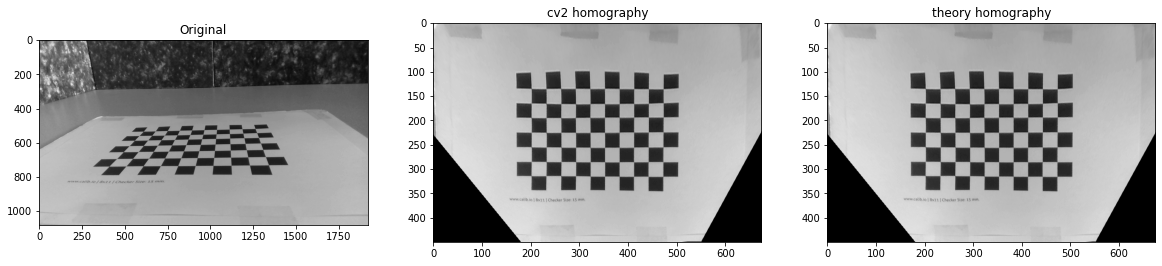

In [140]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (20,20))
ax0.title.set_text('Original')
ax0.imshow(pattern_gray, cmap = 'gray')
ax1.title.set_text('cv2 homography')
ax1.imshow(im_dst, cmap = 'gray')
ax2.title.set_text('theory homography')
ax2.imshow(im_dst_2, cmap = 'gray')


## 3 Anàlisi rendiment homografies estimades

In [141]:
## trobem el chess board de nou en les imatges amb la homografia

corners_h = h @ np.insert(corners2.reshape((70,2)), 2, 1, axis = 1).T 

corners_H = H @ np.insert(corners2.reshape((70,2)), 2, 1, axis = 1).T

corners_h[0]/=corners_h[2]
corners_h[1]/=corners_h[2]
corners_H[0]/=corners_H[2]
corners_H[1]/=corners_H[2]

m = m.reshape((70,2))


In [179]:
def projection_error(points_s, points_d, title):
    df0 = pd.DataFrame({'x': [x[0] for x in points_s], 'y': [x[1] for x in points_s], 'xy': [x for x in points_s], 'points': 'origin'})
    df1 = pd.DataFrame({'x': points_d[0], 'y': points_d[1], 'xy': [(x,y) for x,y in zip(points_d[0], points_d[1])], 'points': 'result'})
    data = pd.concat([df0,df1])
    error = abs(df0['x'] - df1['x'])
    fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (40,10))
    fig.suptitle(title, fontsize=20)
    ax0.title.set_text('Diferència entre punt original i projectat')
    sns.scatterplot(data = data, x = 'x', y = 'y', hue = 'points', ax = ax0)
    ax1.title.set_text('Boxplot entre punt original i projectat (error en mm)')
    sns.boxplot(data = error, ax = ax1)
    ax2.title.set_text('Histograma del error en mm entre punt original i projectat')
    sns.histplot(data = error, binwidth = 0.1, ax = ax2)
    fig.show()

/tmp/ipykernel_4956/4119666483.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


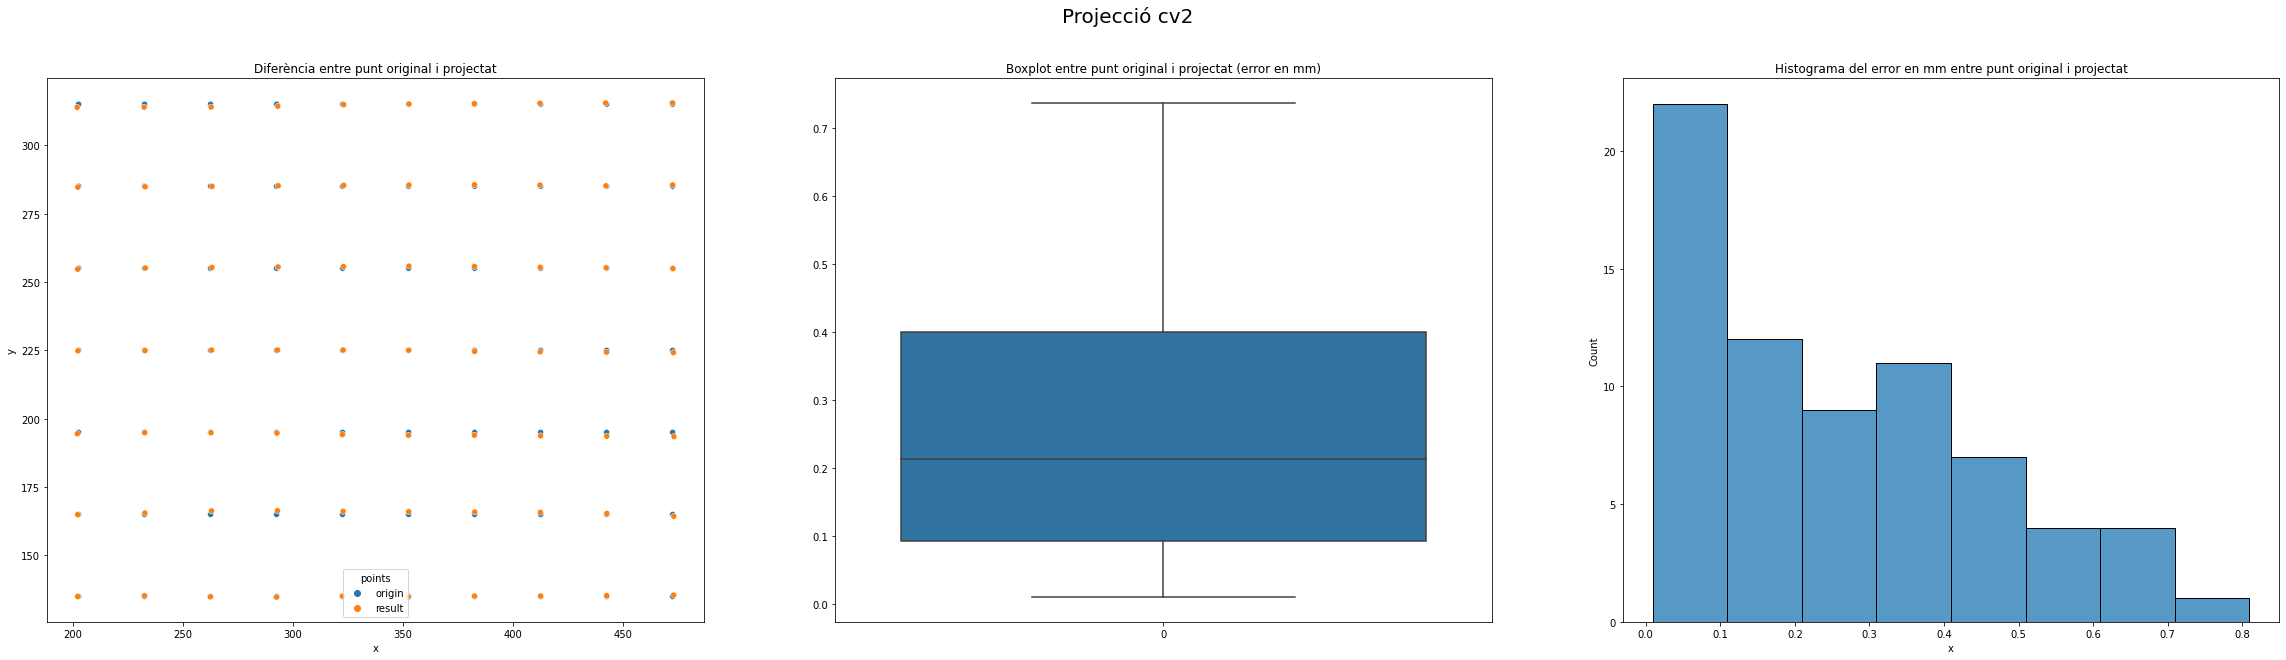

In [180]:
projection_error(m, corners_H, title = 'Projecció cv2')

/tmp/ipykernel_4956/4119666483.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


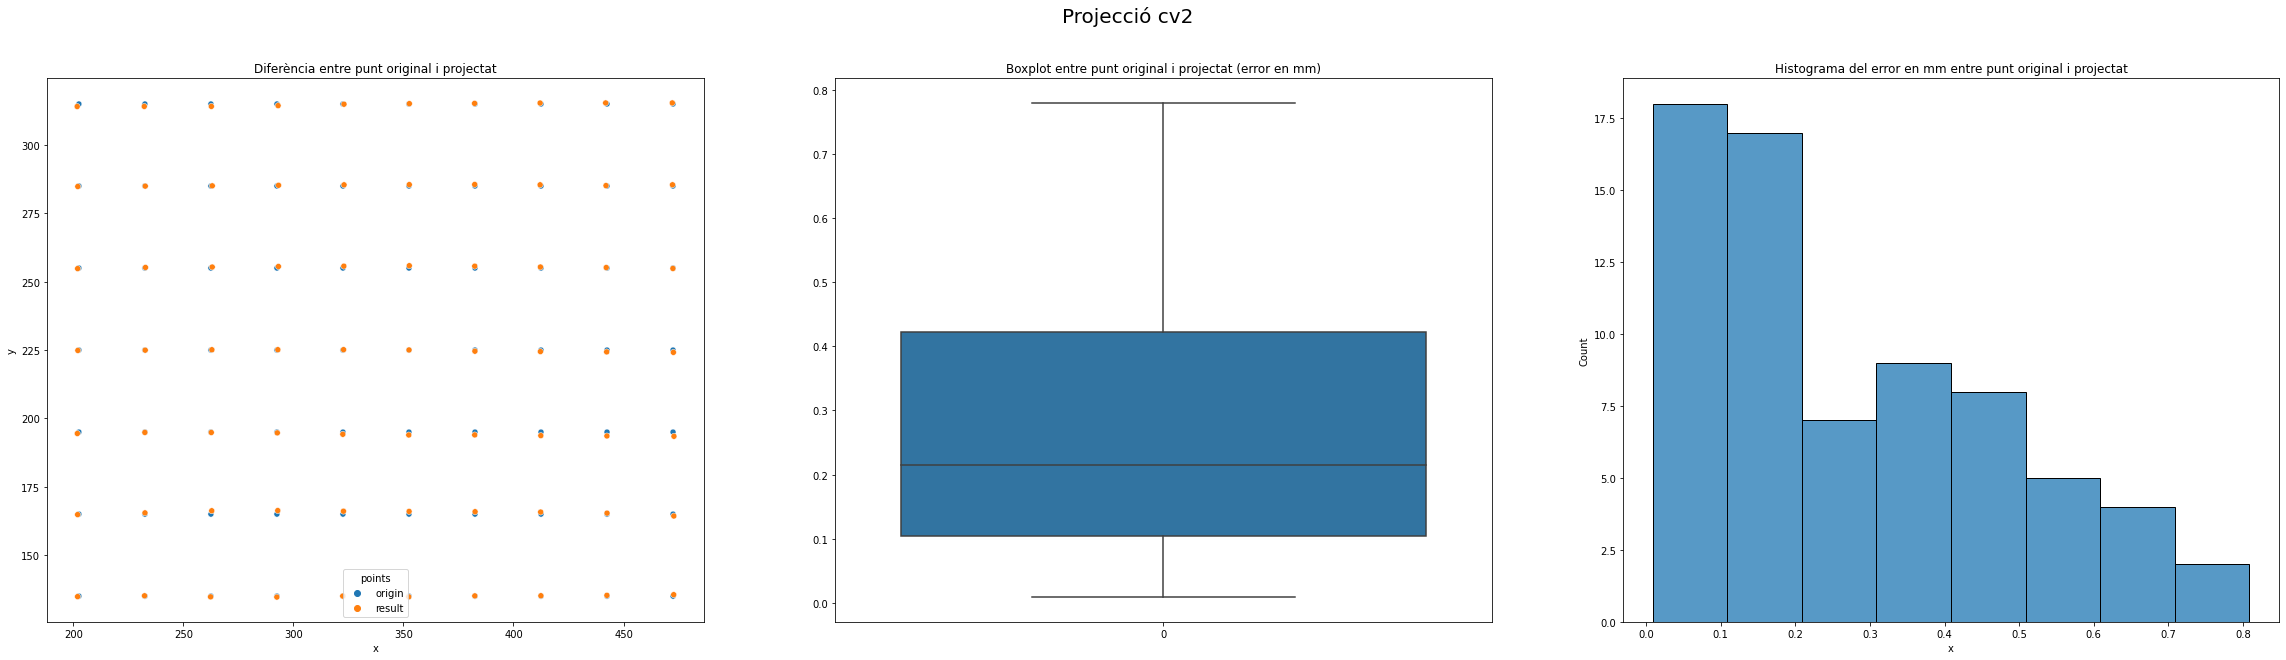

In [181]:
projection_error(m,corners_h, title = 'Projecció cv2')

## 4 Mesura en imatges

El resultat no dona exactament igual que l'esperat ja que la línea detectada per la funció HoughLineP no dóna exactament la línea que uneix els dos cors, o no perfecte, tot i que el tamany i la discriminació de líneas es acorde a las trobades.

In [145]:
images = []
for image in path_img:
    img =  cv2.imread(image)[:,:,::-1]
    img = cv2.warpPerspective(img, H, (675,450))    
    images.append(img)


In [146]:
def detect_lines(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    low_threshold = 100
    high_threshold = 120
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 40  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50  # minimum number of pixels making up a line
    max_line_gap = 20  # maximum gap in pixels between connectable line segments
    line_image = np.copy(img) * 0  # creating a blank to draw lines on
    c=0
    
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

    dist = lambda x1,y1,x2,y2: np.sqrt((x2-x1)**2 + (y2-y1)**2)
    distances = [] #discriminar per distàncies
    points = [(1000,1000,1000,10000)] #discriminar per proximitat  
    areas = [10000] #discriminar per area
    for line in lines:
        for x1,y1,x2,y2 in line:
            distance = dist(x1,y1,x2,y2)
            area = img[x1:x2, y1:y2].mean()
            if 115 > distance > 50 and int(distance) not in distances and round(area,1) not in areas and (points[-1][0] -2  > x1 or x1 > points[-1][0] + 2):
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
                cv2.putText(line_image, str(round(distance/2,2)), (int(x1 + (x2-x1)/2), int(y1 + (y2-y1)/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 200, 200), 2)
                distances.append(int(distance))
                points.append([x1,y1,x2,y2])
                areas.append(round(area,1))
                c+=1
            
                
    lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
    fig = plt.figure(figsize = (15,15))
    fig.suptitle('Distància entre els eixos de cartes')
    plt.imshow(lines_edges)


/tmp/ipykernel_4956/3699276588.py:26: RuntimeWarning: Mean of empty slice.
  area = img[x1:x2, y1:y2].mean()
/home/pgraciae/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


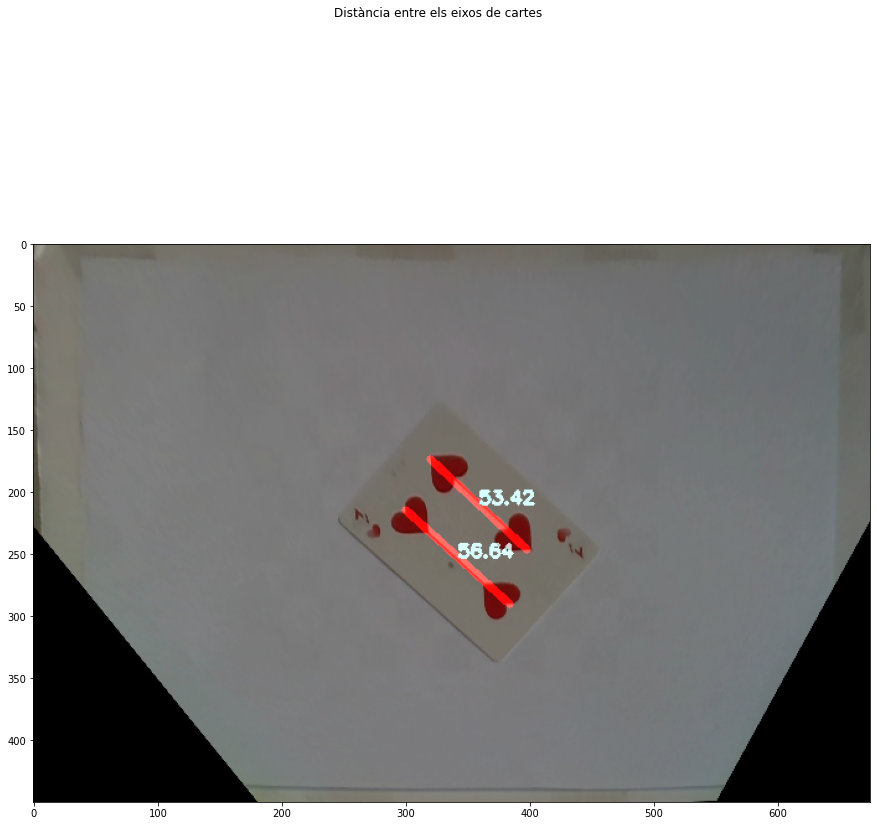

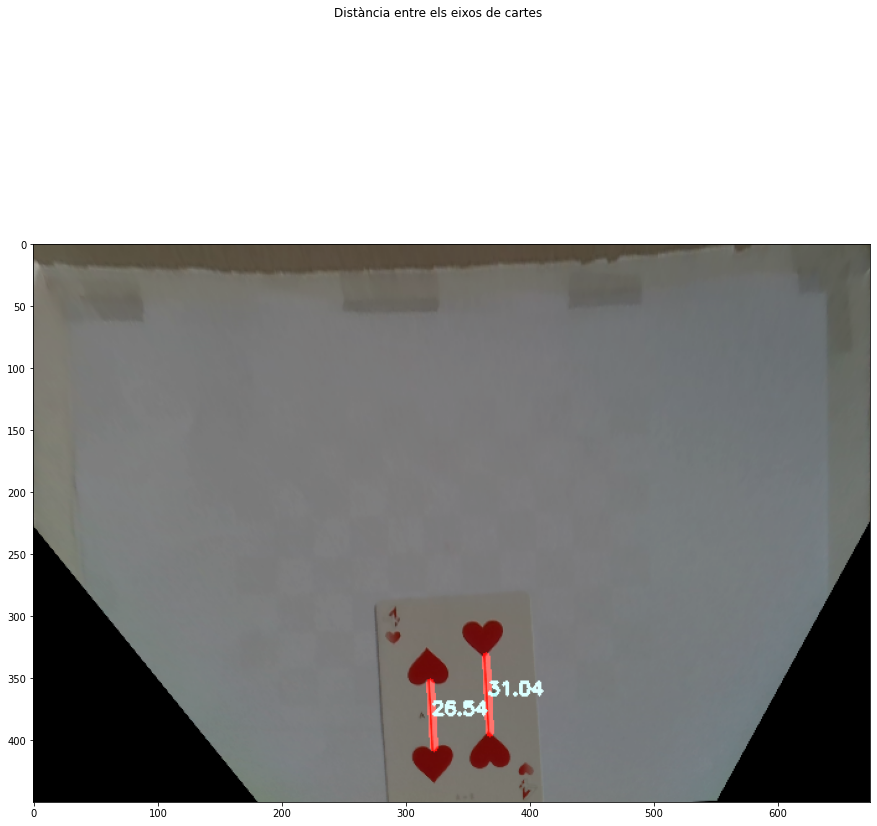

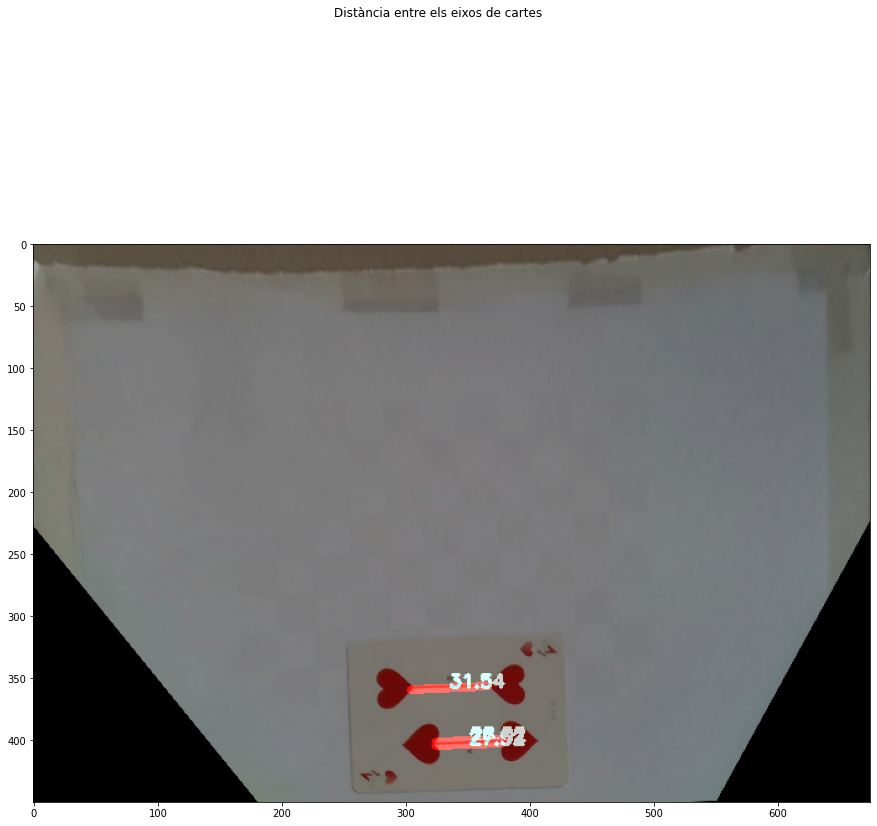

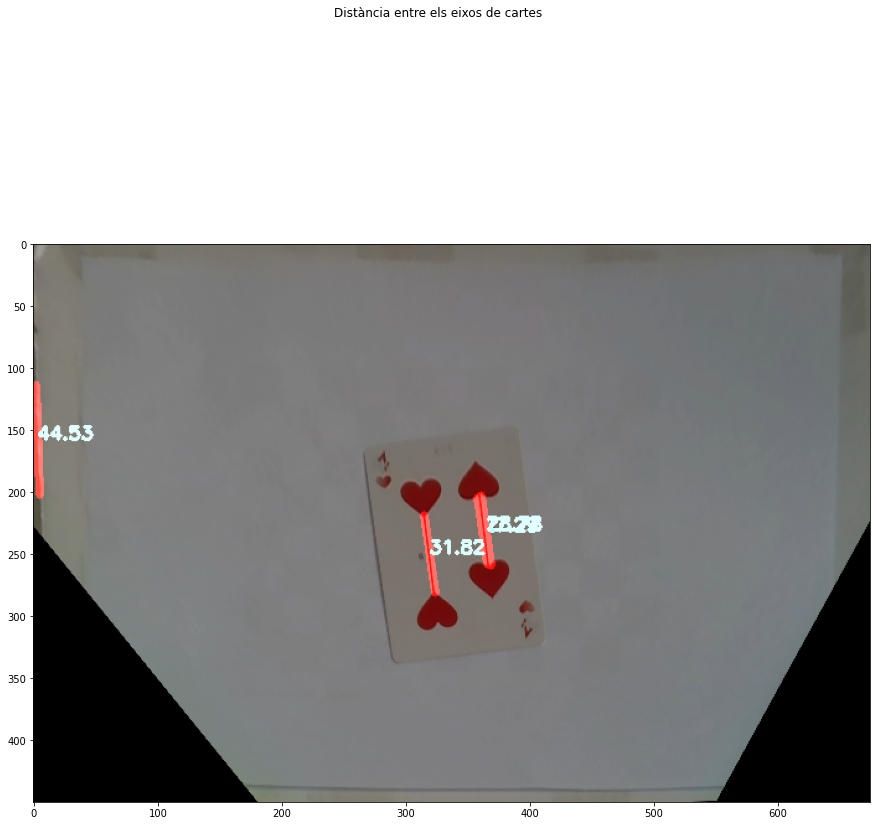

In [147]:
for img in images:
    detect_lines(img)